In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import pickle

def lag_features(df, lags):
    for lag in lags:
        df[f"lag_t-{lag}"] = df.groupby(["WELL_NAME", "CHARWORK"])["LIQ_RATE"].transform(
            lambda x: x.shift(lag))
    return df

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 1

mlp.rcParams['xtick.major.size'] = 15
mlp.rcParams['xtick.major.width'] = 2
mlp.rcParams['xtick.labelsize'] = 15
mlp.rcParams['xtick.color'] = '#4DFC2D'

mlp.rcParams['ytick.major.size'] = 15
mlp.rcParams['ytick.major.width'] = 2
mlp.rcParams['ytick.labelsize'] = 15
mlp.rcParams['ytick.color'] = '#4DFC2D'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#ED6919'
mlp.rcParams['axes.labelcolor'] = '#ED6919'

In [4]:
train_data = pd.read_csv('train228.csv')
gtm = pd.read_csv('../train/gtm.csv')
coords = pd.read_csv('../train/coords.csv')
sampl_sab = pd.read_csv('../train/sample_submission.csv')

train_data["MEASURED_IN_DATE"] = pd.to_datetime(train_data["MEASURED_IN_DATE"])

train_with_lags = lag_features(train_data, lags=[*range(1, 121)])
train_with_lags = train_with_lags.dropna()

train_with_lags.head()

,MEASURED_IN_DATE,WELL_NAME,CHARWORK,LIQ_RATE,WATER_CUT,P_ZAB,INTAKE,lag_t-1,lag_t-2,lag_t-3,...,lag_t-111,lag_t-112,lag_t-113,lag_t-114,lag_t-115,lag_t-116,lag_t-117,lag_t-118,lag_t-119,lag_t-120
120,2017-06-01,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,1,0.0,0.0,80.846916,225.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,2017-06-02,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,1,0.0,0.0,80.846916,225.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122,2017-06-03,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,1,0.0,0.0,80.846916,225.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,2017-06-04,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,1,0.0,0.0,80.846916,225.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124,2017-06-05,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,1,0.0,0.0,80.846916,225.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
y = train_with_lags.LIQ_RATE
to_drop = ["WELL_NAME", "CHARWORK", "WATER_CUT", "LIQ_RATE", "P_ZAB", "INTAKE"
           , "MEASURED_IN_DATE"]

data_to_test_df = train_with_lags.drop(columns=to_drop)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error \
    , mean_absolute_percentage_error, r2_score


VAL_SIZE = 20000

def train_valid_split(data, y=y, train_samples=VAL_SIZE):
    return data[:-train_samples], y[:-train_samples], data[-train_samples:], y[-train_samples:]

def plot_train_valid(model, x_train, y_train, x_test, y_test):
    plt.figure(figsize=(20, 8))
    sns.lineplot(y_train.index, y_train)
    sns.lineplot(y_train.index, model.predict(x_train))

    plt.title('Train')
    plt.legend(['real', 'prediction'])
    plt.show()

    plt.figure(figsize=(20, 8))
    sns.lineplot(y_test.index, y_test)
    sns.lineplot(y_test.index, model.predict(x_test))

    plt.title('Validation')
    plt.legend(['real', 'prediction'])
    plt.show()
    
def get_metrics(model, x_train, y_train, x_test, y_test):
    
    print('\t Train')
    preds = model.predict(x_train)
    print(f'Mean absolute error: {mean_absolute_error(y_train, preds):.3f}')
    print(f'Mean squared error: {mean_squared_error(y_train, preds, squared=False):.3f}')
    print(f'MAPE: {mean_absolute_percentage_error(y_train, preds):.3f}')
    print(f'R2 score: {r2_score(y_train, preds):.3f}')
    
    print('=====================\n \t Test')
    preds = model.predict(x_test)
    print(f'Mean absolute error: {mean_absolute_error(y_test, preds):.3f}')
    print(f'Mean squared error: {mean_squared_error(y_test, preds, squared=False):.3f}')
    print(f'MAPE: {mean_absolute_percentage_error(y_test, preds):.3f}')
    print(f'R2 score: {r2_score(y_test, preds):.3f}')

In [7]:
data_to_test, y_to_test, data_val, y_val = train_valid_split(data_to_test_df)

In [8]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.load_model('../models/basemodel')

# model = CatBoostRegressor(
#     iterations=6000, learning_rate=1e-3, depth=8
#     , loss_function='MAPE', random_state=13)
# model.fit(data_to_test, y_to_test, 
#           eval_set=(data_val, y_val),
#           metric_period=200, plot=True)

	 Train
Mean absolute error: 29.277
Mean squared error: 59.936
MAPE: 0.133
R2 score: 0.963
 	 Test
Mean absolute error: 22.706
Mean squared error: 35.081
MAPE: 0.115
R2 score: 0.967


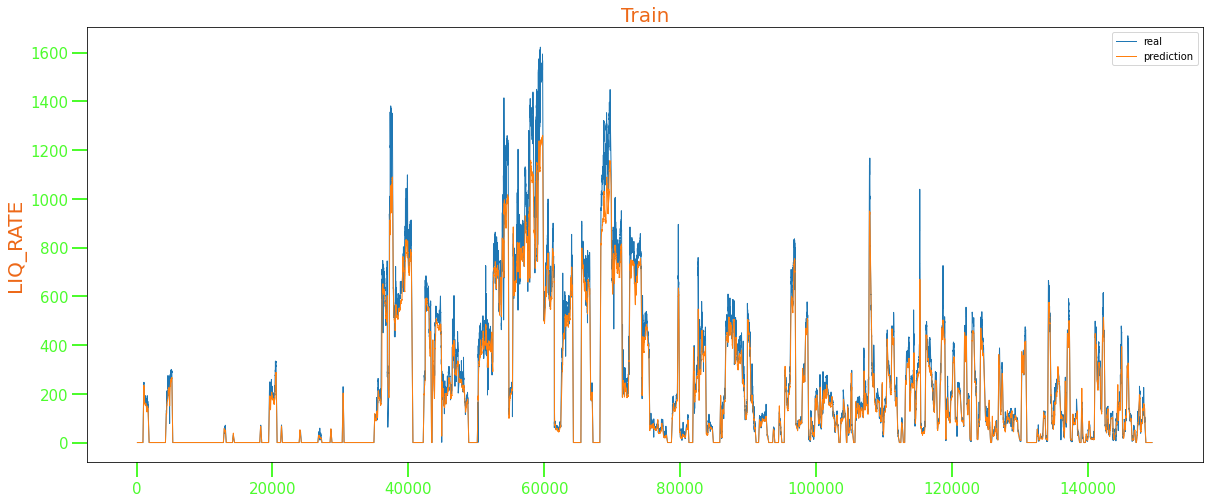

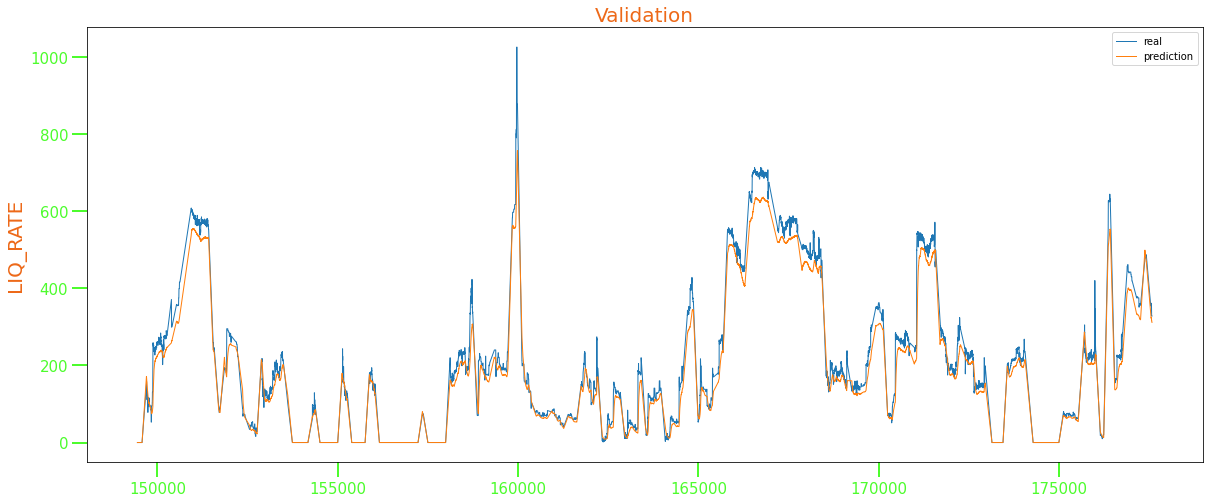

In [9]:
get_metrics(model, data_to_test, y_to_test, data_val, y_val)

plot_train_valid(model, data_to_test, y_to_test, data_val, y_val)

In [10]:
# model.save_model('../models/basemodel')

А теперь добавим данные по выходным

In [11]:
train_with_lags.head()

,MEASURED_IN_DATE,WELL_NAME,CHARWORK,LIQ_RATE,WATER_CUT,P_ZAB,INTAKE,lag_t-1,lag_t-2,lag_t-3,...,lag_t-111,lag_t-112,lag_t-113,lag_t-114,lag_t-115,lag_t-116,lag_t-117,lag_t-118,lag_t-119,lag_t-120
120,2017-06-01,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,1,0.0,0.0,80.846916,225.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,2017-06-02,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,1,0.0,0.0,80.846916,225.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122,2017-06-03,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,1,0.0,0.0,80.846916,225.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,2017-06-04,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,1,0.0,0.0,80.846916,225.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124,2017-06-05,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,1,0.0,0.0,80.846916,225.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
from parser_ import is_free_optim

y = train_with_lags.LIQ_RATE


to_drop = ["WELL_NAME", "CHARWORK", "WATER_CUT", "LIQ_RATE", "P_ZAB", "INTAKE"
           , "MEASURED_IN_DATE"]

data_to_test_df_hol = train_with_lags.drop(columns=to_drop)
data_to_test_df_hol['is_holiday'] = train_with_lags.MEASURED_IN_DATE \
                                    .apply(is_free_optim).astype(int)

In [13]:
data_to_test_df_hol.head()

,lag_t-1,lag_t-2,lag_t-3,lag_t-4,lag_t-5,lag_t-6,lag_t-7,lag_t-8,lag_t-9,lag_t-10,...,lag_t-112,lag_t-113,lag_t-114,lag_t-115,lag_t-116,lag_t-117,lag_t-118,lag_t-119,lag_t-120,is_holiday
120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [14]:
data_to_test_hol, y_to_test_hol, data_val_hol, y_val_hol = train_valid_split(data_to_test_df_hol)

In [15]:
model_hol = CatBoostRegressor()
model_hol.load_model('../models/model_with_holidays')

# model_hol = CatBoostRegressor(iterations=6000, learning_rate=1e-3
#                               , depth=8, loss_function='MAPE'
#                               , cat_features=['is_holiday'], random_state=13)
# model_hol.fit(data_to_test_hol, y_to_test_hol, 
#           eval_set=(data_val_hol, y_val_hol),
#           metric_period=100, plot=True)

# model_hol.save_model('../models/model_with_holidays')

	 Train
Mean absolute error: 29.100
Mean squared error: 59.504
MAPE: 0.131
R2 score: 0.964
 	 Test
Mean absolute error: 22.554
Mean squared error: 34.977
MAPE: 0.114
R2 score: 0.967


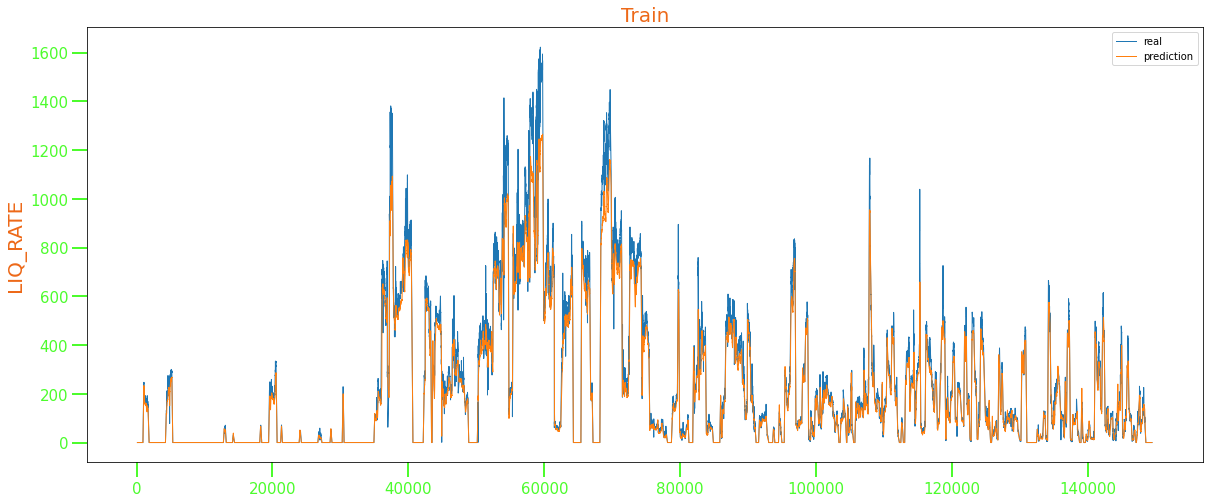

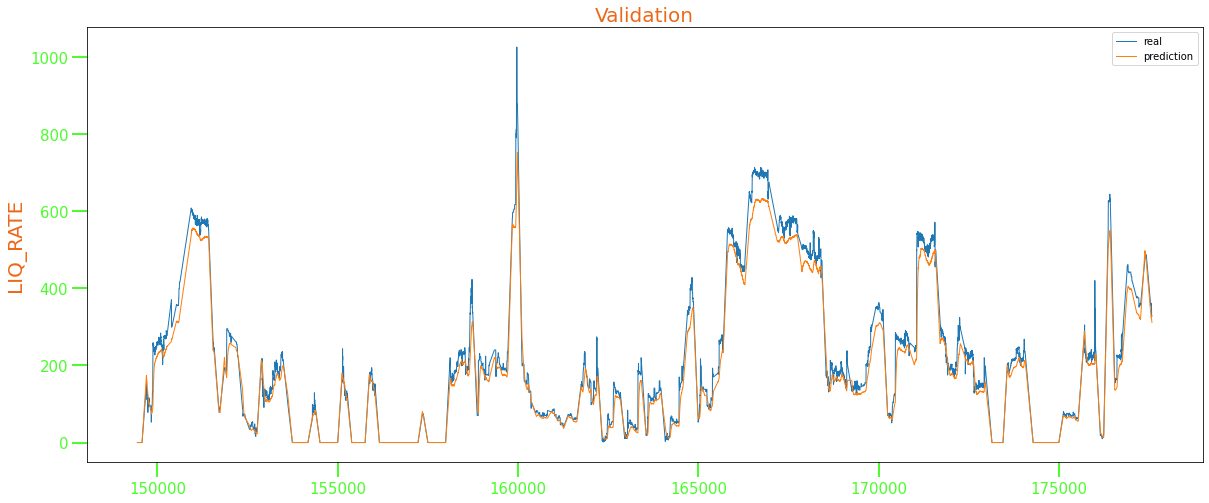

In [16]:
get_metrics(model_hol, data_to_test_hol, y_to_test_hol, data_val_hol, y_val_hol)

plot_train_valid(model_hol, data_to_test_hol, y_to_test_hol, data_val_hol, y_val_hol)

Метрики немного выросли - проверим, есть ли стат значимая разница, сравнив среднее значение **MSE** на валидации

In [17]:
# По-хорошему стоит это сделать бутстрэпом из scipy, но можно и так

def get_bs_loss(model, X_val, y_val, loss=mean_squared_error, 
            n_samples=1500, sample_size=200, random_state=69):
    np.random.seed(69)
    
    x = np.empty(n_samples)
    
    indices = y_val.index
    preds = pd.Series(model.predict(X_val))
    preds.index = indices
    
    for i in range(n_samples):
        sample_ind = np.random.choice(indices, sample_size)
        x[i] = loss(y_val[sample_ind], preds[sample_ind])
        
    return x

In [18]:
mse_base = get_bs_loss(model, data_val, y_val, n_samples=15000, sample_size=400)
mse_holidays = get_bs_loss(model_hol, data_val_hol, y_val_hol, n_samples=15000, sample_size=400)

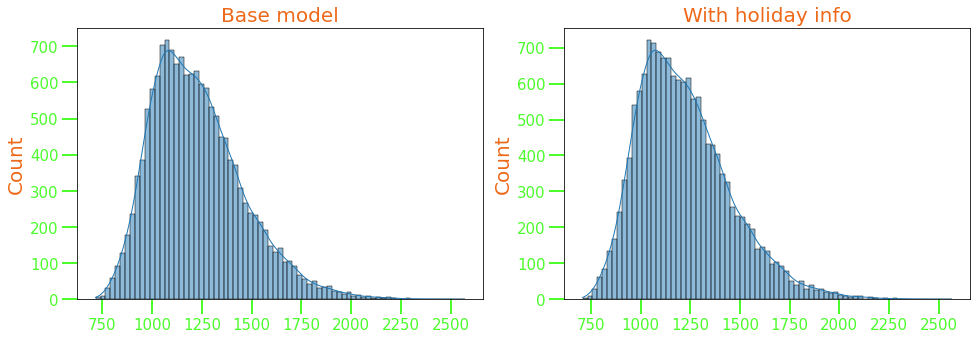

In [19]:
fig = plt.figure(figsize=(16, 5))

fig.add_subplot(1, 2, 1)
sns.histplot(mse_base, kde=True)
# plt.ylim(0, 40)
plt.title('Base model')


fig.add_subplot(1, 2, 2)
sns.histplot(mse_holidays, kde=True)
# plt.ylim(0, 40)
plt.title('With holiday info')

plt.show()

In [20]:
from scipy.stats import ttest_ind, mannwhitneyu

print('Ttest:\t', ttest_ind(mse_base, mse_holidays, alternative='greater').pvalue)
print('Mann-Whitney-Wilcoxon:\t'
      , mannwhitneyu(mse_base, mse_holidays, alternative='greater').pvalue)

Ttest:	 0.0033456385200185484
Mann-Whitney-Wilcoxon:	 0.0010925826019944124


Стат значимая разница есть - фича рабочая. Скорее всего.

Теперь добавим  расстояния и хэширование имен скважин

In [21]:
coords = pd.read_csv('../train/coords.csv')

coords['offset'] = np.sqrt((coords.COORD_X - coords.X2)**2 + (coords.COORD_Y - coords.Y2)**2)
coords.offset = coords.offset.fillna(613)

coords = coords[['WELL_NAME', 'offset']]

In [22]:
import hashlib

def get_hash(well_name):
    return int(hashlib.md5(well_name.encode()).hexdigest(), 16)

In [23]:
y = train_with_lags.LIQ_RATE


to_drop = ["WELL_NAME", "CHARWORK", "WATER_CUT", "LIQ_RATE", "P_ZAB", "INTAKE"
           , "MEASURED_IN_DATE"]

data_to_test_df_features = train_with_lags.drop(columns=to_drop)
data_to_test_df_features['is_holiday'] = train_with_lags.MEASURED_IN_DATE \
                                    .apply(is_free_optim).astype(int)

data_to_test_df_features['offset'] = pd.merge(
    train_with_lags, coords, on='WELL_NAME', how='left'
).offset

data_to_test_df_features['offset'] = data_to_test_df_features['offset'].fillna(
    data_to_test_df_features['offset'].mean()
)

N_BINS = 100

data_to_test_df_features['hash_name'] = train_with_lags.WELL_NAME.apply(get_hash) % 100

In [24]:
data_to_test_df_features.isna().sum().sum()

0

In [25]:
data_to_test_f, y_to_test_f, data_val_f, y_val_f = train_valid_split(data_to_test_df_features)

In [26]:
model_f = CatBoostRegressor()
model_f.load_model('../models/model_with_hashes')

# model_f = CatBoostRegressor(iterations=6000, learning_rate=1e-3
#                               , depth=8, loss_function='MAPE'
#                               , cat_features=['is_holiday', 'hash_name'], random_state=13)
# model_f.fit(data_to_test_f, y_to_test_f, 
#           eval_set=(data_val_f, y_val_f),
#           metric_period=100, plot=True)

# model_f.save_model('../models/model_with_hashes')

<!-- N_BINS = 100

data_to_test_df_features['name_hash'] = train_with_lags.WELL_NAME.apply(get_hash) % 100 

data_to_test_df_features['offset'] = pd.merge(
        train_with_lags, coords, on='WELL_NAME', how='left'
).offset

data_to_test_df_features['offset'] = data_to_test_df_features['offset'].fillna(
    data_to_test_df_features['offset'].mean()
)

data_to_test_df_features.head() -->

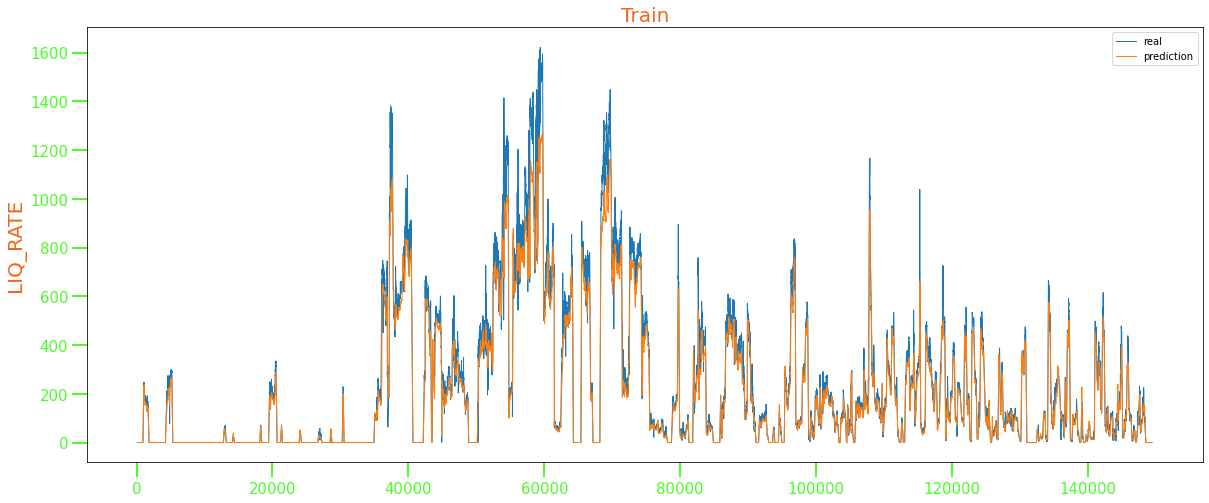

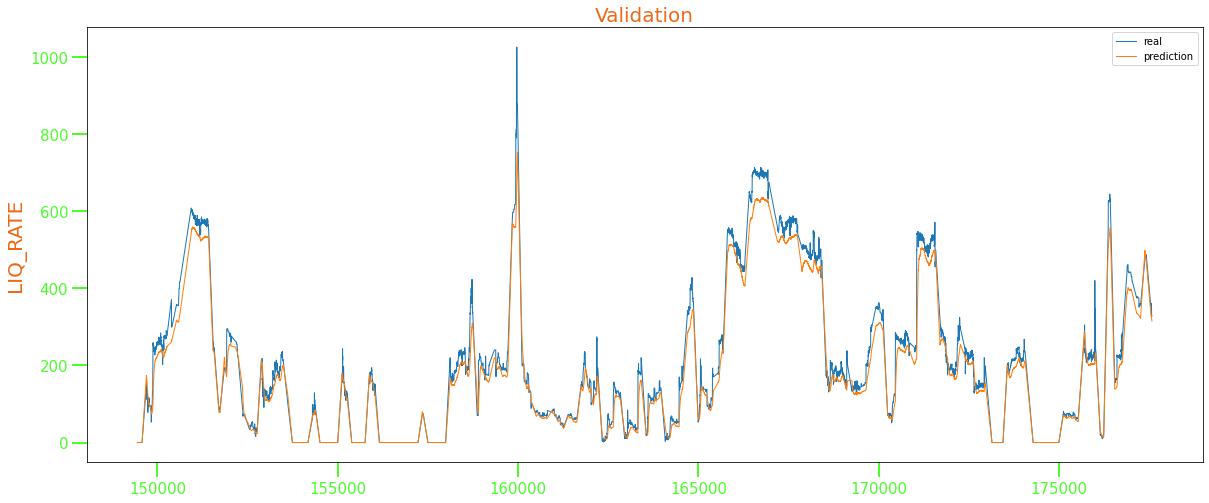

In [27]:
plot_train_valid(model_f, data_to_test_f, y_to_test_f, data_val_f, y_val_f)

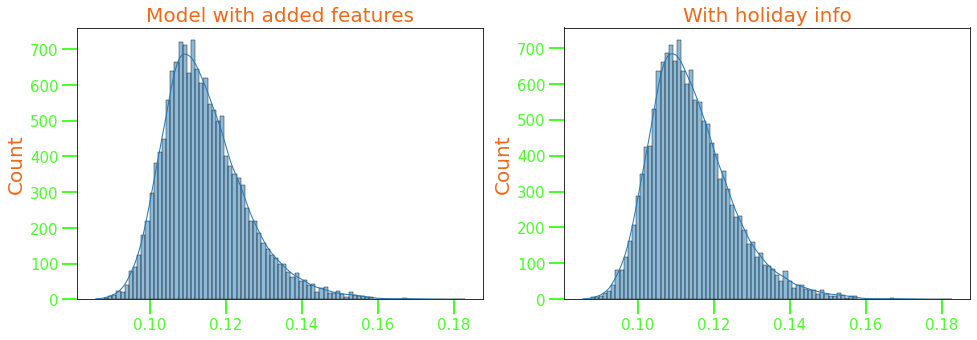

In [28]:
fig = plt.figure(figsize=(16, 5))

mse_holidays = get_bs_loss(model_hol, data_val_hol, y_val_hol
                           , mean_absolute_percentage_error,  n_samples=15000, sample_size=400)
mse_f = get_bs_loss(model_f, data_val_f, y_val_f
                           , mean_absolute_percentage_error, n_samples=15000, sample_size=400)


fig.add_subplot(1, 2, 1)
sns.histplot(mse_f, kde=True)
# plt.ylim(0, 40)
plt.title('Model with added features')

fig.add_subplot(1, 2, 2)
sns.histplot(mse_holidays, kde=True)
# plt.ylim(0, 40)
plt.title('With holiday info')

plt.show()

In [29]:
print('Ttest:\t', ttest_ind(mse_f, mse_holidays, alternative='less').pvalue)
print('Mann-Whitney-Wilcoxon:\t'
      , mannwhitneyu(mse_f, mse_holidays, alternative='less').pvalue)

Ttest:	 0.9995532291673989
Mann-Whitney-Wilcoxon:	 0.9997397089665396


Модель, обучающаяся на выходных, дает лучший скор, чем модель со сдвигом скважины и хэшом

Попробуем обучить модель без хэшей - необязательная категориальная переменная может сильно тормозить обучение

In [30]:
data_to_test_off, y_to_test_off \
, data_val_off, y_val_off = train_valid_split(data_to_test_df_features.drop('hash_name', axis=1))

In [31]:
model_off = CatBoostRegressor()
model_off.load_model('../models/model_with_offset')

# model_off = CatBoostRegressor(iterations=6000, learning_rate=1e-3
#                               , depth=8, loss_function='MAPE'
#                               , cat_features=['is_holiday'], random_state=13)
# model_off.fit(data_to_test_off, y_to_test_off, 
#           eval_set=(data_val_off, y_val_off),
#           metric_period=100, plot=True)

# model_off.save_model('../models/model_with_offset')

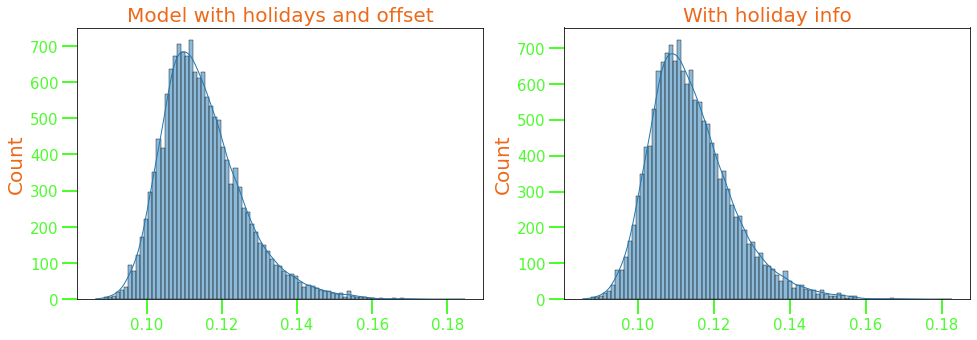

In [32]:
fig = plt.figure(figsize=(16, 5))

mse_holidays = get_bs_loss(model_hol, data_val_hol, y_val_hol
                           , mean_absolute_percentage_error, n_samples=15000, sample_size=400)
mse_off = get_bs_loss(model_off, data_val_off, y_val_off
                           , mean_absolute_percentage_error, n_samples=15000, sample_size=400)


fig.add_subplot(1, 2, 1)
sns.histplot(mse_off, kde=True)
# plt.ylim(0, 40)
plt.title('Model with holidays and offset')

fig.add_subplot(1, 2, 2)
sns.histplot(mse_holidays, kde=True)
# plt.ylim(0, 40)
plt.title('With holiday info')

plt.show()

In [33]:
mse_off.mean()

0.11482718543403407

In [34]:
mse_holidays.mean()

0.11406600346544463

In [35]:
print('Ttest:\t', ttest_ind(mse_off, mse_holidays, alternative='less').pvalue)
print('Mann-Whitney-Wilcoxon:\t'
      , mannwhitneyu(mse_off, mse_holidays, alternative='less').pvalue)

Ttest:	 0.9999999994517015
Mann-Whitney-Wilcoxon:	 0.9999999999680822


In [71]:
# pytorch model, second df row, forecast horizon
def predict_step_by_step(model, row, days):
    forecasting_for_days = []
    new_arr_to_predict = row.to_numpy().tolist()
    for i in range(days):
        tensor_to_predict = np.array(new_arr_to_predict)

        predict = model.predict(tensor_to_predict)[0]
        forecasting_for_days.append(predict)
        new_arr_to_predict = [new_arr_to_predict[0][:-1]]
        new_arr_to_predict[0].insert(0, forecasting_for_days[-1])
    
    return forecasting_for_days


#df on 120 cols of lags 
from sklearn.linear_model import Lasso

model = Lasso()

# model = CatBoostRegressor()
# model.load_model('../models/out_cbr')
model.fit(data_to_test_df, y)

forecast = predict_step_by_step(model, data_to_test_df.tail(1), 120)
#hochu lizat pizdu...

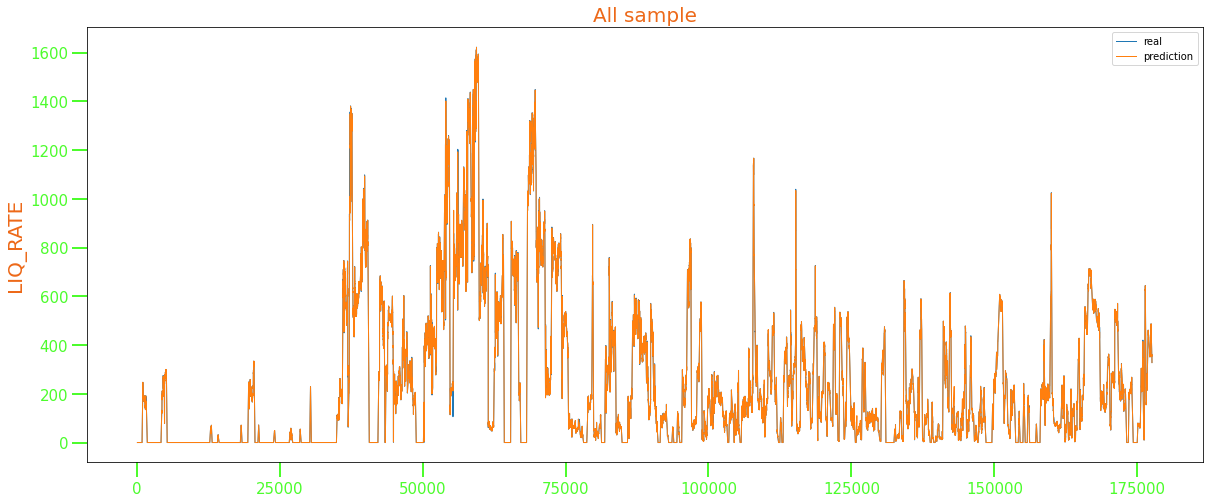

In [72]:
plt.figure(figsize=(20, 8))
sns.lineplot(y.index, y)
sns.lineplot(y.index, model.predict(data_to_test_df))

plt.title('All sample')
plt.legend(['real', 'prediction'])
plt.show()

In [73]:
def plot_results(actual_time_series, predicted_values, len_train_data, y_name = 'Parameter'):
    plt.figure(figsize=(16, 8))
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    # Plot black line which divide our array into train and test
    plt.axvline(len_train_data, c = 'red', ls = '--', linewidth = 1, label = 'Entry point')
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15, loc='upper left')
    plt.grid()
    plt.show()

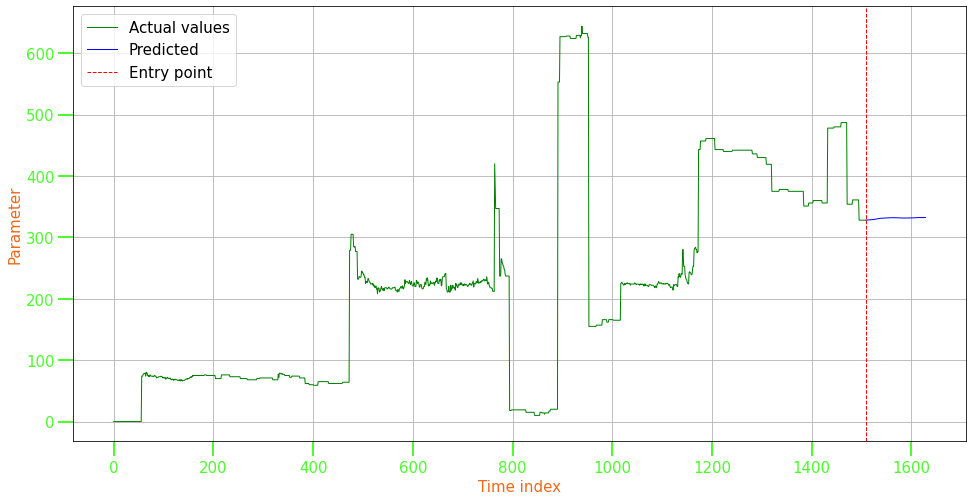

In [74]:
plot_results(actual_time_series = train_with_lags[140000:]['LIQ_RATE'],
             predicted_values = forecast, 
             len_train_data = len(train_with_lags[140000:]))

In [ ]:
data_to_test_df_features.isna().sum()